In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import importlib as ilib
import random
from typing import *

import sys
import os
sys.path.append(os.path.abspath("../frbfuncs")) # add frbfuncs folder as a possible candidate to search functions
import cosmology as c
import ktau as kt

# Power Law Distribution

In [2]:
import sim
ilib.reload(sim)

<module 'sim' from '/Users/williamhuang/Documents/GitHub/FRB Project/frbfuncs/sim.py'>

## Testing
Functions from sim package used in this section:
- sim.rndm(a, b, g, size, seed)
- sim.get_expected(l, r, a, b, g, n)

In [3]:
## compare random samples to theoretical distribution to see whether or not this random thing works

# generate data
n = 100000 #number of data points in sample
seed = 0
a, b, g = 2, 6, -1.1 #left end, right end, power in power law distribution
data = sim.rndm(a, b, g, size=n, seed=seed) #generate data
print(f'{n} points generated')

# plot parameters
bins = 100 # number of bins in histogram

edges = np.linspace(a, b, bins+1) #edges
l, r = edges[:-1], edges[1:] #left edges vs right edges
x = (l+r)/2 # average of left and right edges; this gives central values
pdf = sim.get_expected(l, r, a, b, g, n) #expected number of points per bin
print(f'theoretical number of points: {sum(pdf)}') #confirm # of total points is identical

100000 points generated
theoretical number of points: 99999.99999999996


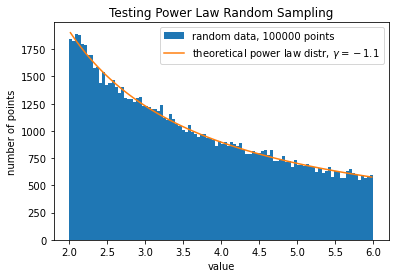

In [4]:
#plot histogram of data vs. expected
plt.hist(data, bins=bins, label=f'random data, {n} points')
plt.plot(x, pdf, label=f'theoretical power law distr, $\gamma={g}$')
plt.title('Testing Power Law Random Sampling')
plt.ylabel('number of points')
plt.xlabel('value')
plt.legend()
plt.show()

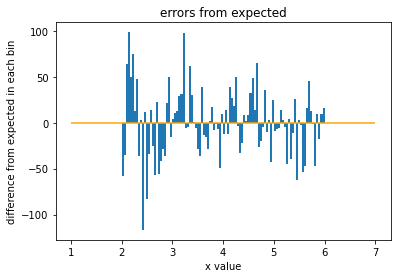

In [6]:
# plot errors
counts, bin_edges = np.histogram(data, bins=bins) #identical to above plot
plt.bar(x, counts-pdf, width=(b-a)/bins)
plt.hlines(0, a-1, b+1, colors='orange')
plt.title('errors from expected')
plt.ylabel('difference from expected in each bin')
plt.xlabel('x value')
plt.show()

In [7]:
#confirm that errors add up to ~0
sum(counts-pdf)

-6.821210263296962e-13

# Kendall-$\tau$ Sampling
functions used:
- sim.frb_sample(zparams, Lparams, size, seed, pdSeries)

In [8]:
#get the up to date package
# ilib.reload(sim)
# ilib.reload(kt)

<module 'ktau' from '/Users/williamhuang/Documents/GitHub/FRB Project/frbfuncs/ktau.py'>

## Testing for a Single Sample

Text(0, 0.5, 'L (arbitrary units)')

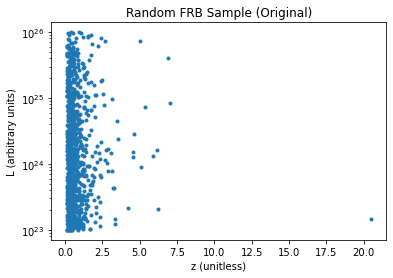

In [79]:
# generate data for one random sample
size = 1000
seed = 13
zsamp, Lsamp = sim.frb_sample(zparams=[-1.0, 1.0], Lparams=[1e23, 1e26, -1.2], size=size, seed=seed)
plt.scatter(zsamp, Lsamp, marker='.')
plt.yscale('log')
plt.title('Random FRB Sample (Original)')
plt.xlabel('z (unitless)')
plt.ylabel('L (arbitrary units)')

In [80]:
#define some minimum luminosity functions

def standard(zs, Ls=None, F=5, alpha=1):
    return c.E_v(Fs=F, z=zs, alpha=alpha)

def allow_all(zs, Ls=None):
    return 1e20*zs + 1e22

minL_func = standard #set the function to be used

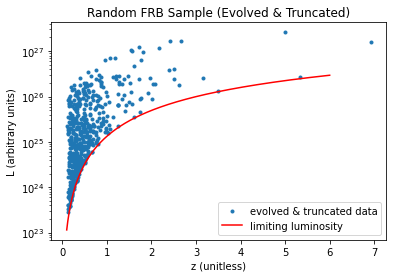

In [81]:
#evolve its luminosity and apply a truncation:
truek = 3
Levo = Lsamp * kt.g_complex(zsamp, truek) #evolve sample
minL = minL_func(zs=zsamp, Ls=Levo)

#truncate
minL_trunc, L_trunc, z_trunc = kt.truncate(minL, Levo, zsamp)

zlim = np.linspace(0.1, 6, 1000)
#plt.scatter(zsamp, Levo, marker='.', alpha=0.3, label='evolved (not truncated) data')
plt.scatter(z_trunc, L_trunc, marker='.', label='evolved & truncated data')
plt.plot(zlim, minL_func(zlim), color='red', label='limiting luminosity')
plt.yscale('log')
plt.title('Random FRB Sample (Evolved & Truncated)')
plt.ylabel('L (arbitrary units)')
plt.xlabel('z (unitless)')
plt.legend()
plt.show()

In [82]:
# output size of sample after truncation
print(len(L_trunc))

535


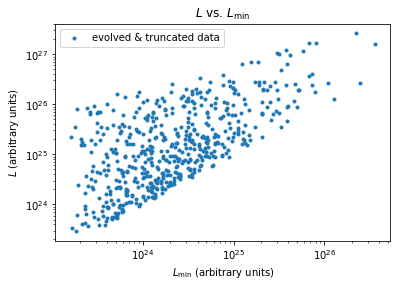

In [83]:
# plot L vs. L_lim
plt.scatter(minL_trunc, L_trunc, marker='.', label='evolved & truncated data')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$L_\\mathrm{min}$ (arbitrary units)')
plt.ylabel('$L$ (arbitrary units)')
plt.title('$L$ vs. $L_\\mathrm{min}$')
plt.legend()
plt.show()

In [84]:
#generate taus for a given sample
num = 20
ks = np.linspace(truek-3, truek+3, num)
taus = np.zeros(num)
for i,k in enumerate(ks):
    taus[i] = kt.ktau_E(L_trunc, minL_trunc, z_trunc, gfunc=kt.g_complex, k=k, params="default")

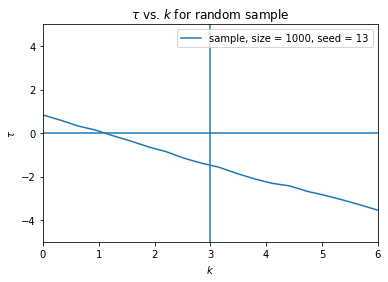

In [85]:
#plot of tau vs k for one random sample

plt.plot(ks, taus, label=f'sample, size = {size}, seed = {seed}')
plt.title('$\\tau$ vs. $k$ for random sample')
plt.ylabel('$\\tau$')
plt.xlabel('$k$')
plt.hlines([0], truek-3, truek+3)
plt.vlines([truek], -5, 5)
plt.ylim([-5, 5])
plt.xlim([truek-3, truek+3])
plt.legend()
plt.show()

### observations
Shape of $\tau$ vs. $k$ graph:

- always seems to be roughly a straight line
- deviates more when power law distr for $L$ is changed to a more negative power  

Seed:  

- seed seems to randomly affect the y intercept

Size of Sample:

- size affects slope: the larger the size, the steeper the slope (higher absolute magnitude)

Truncation: 

- truncation affects slope: even when compared to untruncated samples with the same size as truncated samples counting *only points that are above the truncation line*, slope is still shallower for truncation

## distribution of $\tau$ at $k=\mathrm{truek}$ across samples

In [87]:
# generate a bunch of random seeds, all connected to one master seed
masterSeed = 0
num_seeds = 1000

random.seed(masterSeed)
seeds = []
for i in range(num_seeds):
    seeds.append(random.randint(0, 2e9))

In [69]:
# for each random seed, generate sample, determine tau at k = truek
taus_at_truek = np.zeros(num_seeds)
size = 1000 #original size of each sample
truek = 3 #true value of k
minL_func = standard #set the minimum luminosity function

avg_size_trunc = 0 #track average size after truncation

for i, seed in enumerate(seeds):
    zsamp, Lsamp = sim.frb_sample(zparams=[-1.0, 1.0], Lparams=[1e23, 1e26, -1.2], size=size, seed=seed)
    Levo = Lsamp * kt.g_complex(zsamp, truek)
    minL = minL_func(zsamp, Levo)
    minL_trunc, L_trunc, z_trunc = kt.truncate(minL, Levo, zsamp)
    avg_size_trunc += len(minL_trunc)
    taus_at_truek[i] = kt.ktau_E(L_trunc, minL_trunc, z_trunc, gfunc=kt.g_complex, k=truek, params="default")

avg_size_trunc /= num_seeds

In [70]:
# show average size after truncation
print(avg_size_trunc)

340.107


### Variation in $\tau$ at $k=\mathrm{truek}$

mean: -0.09791219984467316
std:  1.0261506730910832


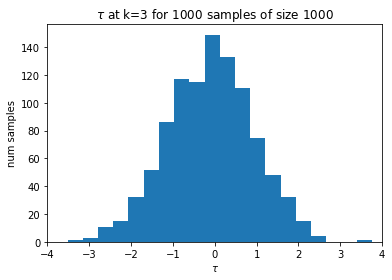

In [73]:
print("mean:", np.mean(taus_at_truek))
print("std: ", np.std(taus_at_truek))
plt.hist(taus_at_truek, bins=20)
plt.title(f'$\\tau$ at k={truek} for {num_seeds} samples of original size {size}')
plt.ylabel('num samples')
plt.xlabel('$\\tau$')
plt.xlim([-4, 4])
if max(taus_at_truek) > 4 or min(taus_at_truek) < -4:
    print("some data is out of the range of this graph.")
plt.show()

### observations
- mean $\approx 0$ and $\sigma \approx 1$ regardless of original sample size or $k$!
- this makes sense, since $\tau$ should be a normalized metric

## next up: Variation in $k$ for $\tau = 0$.
- can be done quicker using a binary search in $k$
- (could be done even quicker using Newton's method, especially since it's roughly a straight line) (TODO)

### binary search for k, single sample

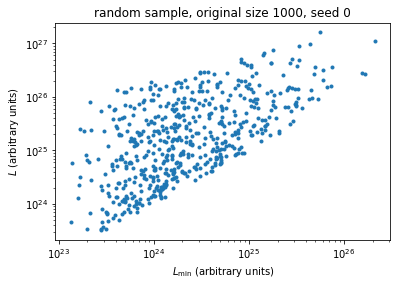

In [92]:
#create one sample
seed = 0
size = 1000 #original size of each sample
truek = 3 #true value of k
minL_func = standard #set the minimum luminosity function

zsamp, Lsamp = sim.frb_sample(zparams=[-1.0, 1.0], Lparams=[1e23, 1e26, -1.2], size=size, seed=seed)
Levo = Lsamp * kt.g_complex(zsamp, truek)
minL = minL_func(zsamp, Levo)
minL_trunc, L_trunc, z_trunc = kt.truncate(minL, Levo, zsamp)

#make sure everything looks okay:
plt.scatter(minL_trunc, L_trunc, marker='.')
plt.yscale('log')
plt.xscale('log')
plt.title(f'random sample, original size {size}, seed {seed}')
plt.xlabel('$L_\\mathrm{min}$ (arbitrary units)')
plt.ylabel('$L$ (arbitrary units)')
plt.show()

In [95]:
# binary search function
# note that if k outside of the +-5 range will default to edge of this range

def binary_search_k(minL, L, z, truek, precision=1e-3):
    lo = truek-5
    hi = truek+5
    
    while hi - lo > precision:
        kmid = (hi+lo)/2
        taumid = kt.ktau_E(L, minL, z, gfunc=kt.g_complex, k=kmid, params="default")
        
        if taumid > 0:
            lo = kmid
        elif taumid < 0:
            hi = kmid
        else:
            return kmid
    
    return (hi+lo)/2

#test the function on this sample:
print(binary_search_k(minL_trunc, L_trunc, z_trunc, 3))

3.27557373046875


In [98]:
#generate taus for a given sample
num = 20
ks = np.linspace(truek-3, truek+3, num)
taus = np.zeros(num)
for i,k in enumerate(ks):
    taus[i] = kt.ktau_E(L_trunc, minL_trunc, z_trunc, gfunc=kt.g_complex, k=k, params="default")
    
kfound = binary_search_k(minL_trunc, L_trunc, z_trunc, truek)

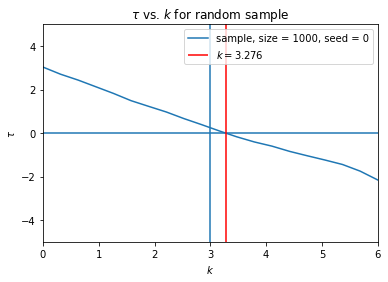

In [102]:
#plot of tau vs k for one random sample. compare with binary search result

plt.plot(ks, taus, label=f'sample, size = {size}, seed = {seed}')
plt.title('$\\tau$ vs. $k$ for random sample')
plt.ylabel('$\\tau$')
plt.xlabel('$k$')
plt.hlines([0], truek-3, truek+3)
plt.vlines([truek], -5, 5)
plt.vlines([kfound], -5, 5, color='red', label=f'$k=${round(kfound, 3)}')
plt.ylim([-5, 5])
plt.xlim([truek-3, truek+3])
plt.legend()
plt.show()

## binary search for many samples

In [119]:
# generate a bunch of random seeds, all connected to one master seed
masterSeed = 0
num_seeds = 100

random.seed(masterSeed)
seeds = []
for i in range(num_seeds):
    seeds.append(random.randint(0, 2e9))

In [120]:
# for each random seed, generate sample, then binary search for k
kfounds = np.zeros(num_seeds)
size = 1000 #original size of each sample
truek = 3 #true value of k
minL_func = standard #set the minimum luminosity function

avg_size_trunc = 0 #track average size after truncation

for i, seed in enumerate(seeds):
    #make the sample
    zsamp, Lsamp = sim.frb_sample(zparams=[-1.0, 1.0], Lparams=[1e23, 1e26, -1.2], size=size, seed=seed)
    Levo = Lsamp * kt.g_complex(zsamp, truek)
    minL = minL_func(zsamp, Levo)
    minL_trunc, L_trunc, z_trunc = kt.truncate(minL, Levo, zsamp)
    avg_size_trunc += len(minL_trunc)
    
    kfounds[i] = binary_search_k(minL_trunc, L_trunc, z_trunc, truek)

avg_size_trunc /= num_seeds

mean: 3.076202392578125
std:  1.111309129706825


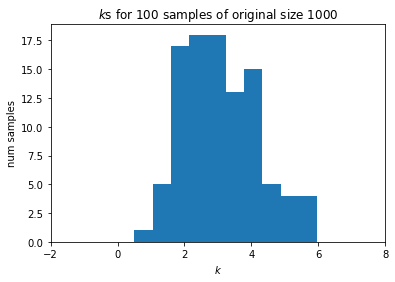

In [121]:
print("mean:", np.mean(kfounds))
print("std: ", np.std(kfounds))
plt.hist(kfounds, bins=10)
plt.title(f'$k$s for {num_seeds} samples of original size {size}')
plt.ylabel('num samples')
plt.xlabel('$k$')
plt.xlim([truek-5, truek+5])
plt.show()